# Appendix
<br>
<br>

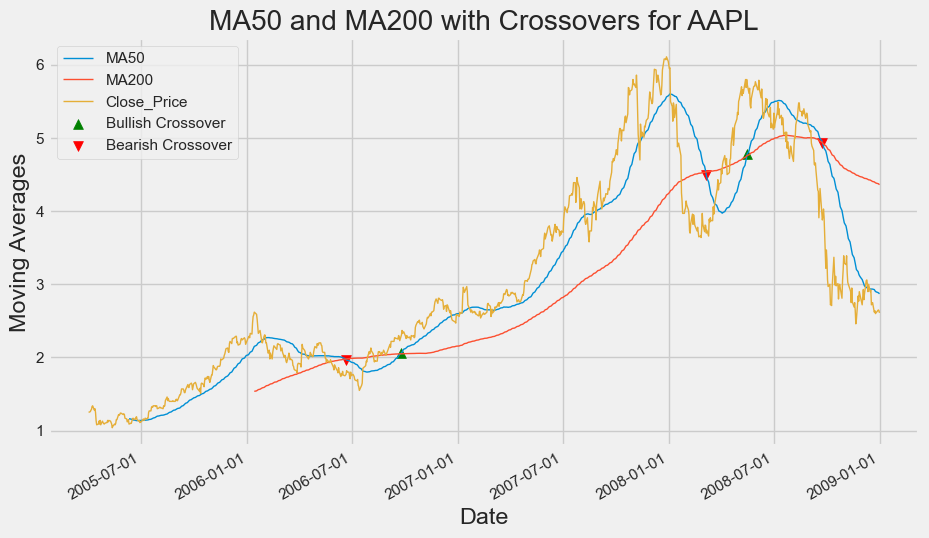

## Introduction

In the main part of this project we looked for the best model for predicting profitable crossover events.

Well, is this "best model" good enough statistically?

We’ll try answering this question in this appendix by calculating the Expected Value of the profit (or loss) which would have been obtained if transactions were activated according to the model’s predictions of profitable events (Positive predictions – either True or False).

In simpler terms, the Expected Value is a weighted average, where each possible outcome is multiplied by its probability of occurrence. It stands for the "average" value we would expect to obtain if we were to repeat the random experiment an infinite number of times. 

The concept of Expected Value is widely used in various fields to make predictions and decisions based on probabilistic models.

In this case we are interested in predicting profitable transactions and whether or not acting according to the model's predictions many times will result in a profit or loss.

The predictions of not profitable ('Profitable' feature's value is 0) are not of interest as they will not be used as triggers for any transaction's activation.

For analyzing the predictions of 'Profitable' = 1 I'll calculate the expected value with the following formula:

***E = Pr(TP) * Average(P|TP) + Pr(FP) * Average(P|FP)***

In this formula:
<br>***E*** is the expected value<<br>***Pr(TP)*** is the probability of predicting correctly the value 1 fot 'Profitable' (TP is True Positive)
<br>***Average(P|TP)*** is the average profit rate (presented in the dataset by the '%Change' feature) of the TP predictions
<br>***Pr(TF)*** is the probability of predicting wrongly the value 1 for 'Profitable' (FP is False Positive)
<br>***Average(P|FP)*** is the average profit rate (presented in the dataset by the '%Change' feature) of the FP predictions.

Though this is the formula for calculating the Expected Value of the profit, there is a simpler way available (which is proved mathematically to get the same result as the above formula for the Expected Value) – using the average value of all the profit/loss values (the ‘%Change’ values) of all the Positive predicted events (True and False).

We check its statistical significance by using the t-test.

The ‘%change’ feature is distributed normally (as can be seen in the histogram plot) with a mean of (-0.468) (as can be seen in its statistics presented by the ‘describe’ method). 

The null hypothesis we’ll use is that the mean of the population is -0.468% (as will be shown) and the test is if the mean of the Positive predicted events is significantly different from the population’s mean and the null hypothesis can be rejected.

If the null hypothesis can be rejected we can say that the selected model's prediction is statistically significant.


#### A technical note:

The process to follow here requires, as explained above, the values of '%Change' also for the non-profitable events in the dataset. These values are not in the crossover events dataset we used in the main part hence it requires going back to the full period data and re-creating a new dataset of only the crossover events, which will include now also the '%Change' values for the non-profitable events.

Since previously, in the main part of the project, many zero values in various features were checked and replaced manually (using Excel file), the process of creating the new crossover dataset was complicated and long and it is not the main issue in this Appendix. So we'll skip this part here and directly load the already prepared crossover dataset - 'appendix_cross_df.xlsx' and take it from there.

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd
from datetime import datetime
import math
import joblib

# Modelling Algorithms

# Classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis , QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

# Regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


# Modelling Helpers
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score


# Preprocessing
from sklearn.preprocessing import MinMaxScaler , StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
import missingno as msno


# Evaluation metrics

import sklearn.metrics as skmet
import scipy.stats as stats

# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score, log_loss, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


# Visualisation
#import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.dates as mdates # needed for plotting x-ticks with intervals
from matplotlib.ticker import MultipleLocator # needed for plotting x-ticks with intervals
import sweetviz as sv
import seaborn as sns
sns.set()
plt.style.use('fivethirtyeight')

### Viewing the new dataset of crossover events for the purpose of this Appendix

In [2]:
app_cross_df = pd.read_excel('appendix_cross_df.xlsx')

In [3]:
app_cross_df.shape

(4124, 26)

In [4]:
app_cross_df.head(1)

,original index,Ticker,Date,Open,Close,Volume,quarter,Asset Turnover,Current Ratio,Days Sales In Receivables,...,ROE - Return On Equity,Receiveable Turnover,Return On Tangible Equity,Days,MA50,MA200,Crossover,Profitable,%Change,Ticker_encoded
0,318,A,2006-07-06,19.4,19.6,2054200,3,0.1603,2.5128,61.9613,...,5.6962,1.4525,6.5237,461,21.499,21.51925,-1,0,-2.040816,0.55


In [5]:
app_cross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4124 entries, 0 to 4123
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   original index             4124 non-null   int64         
 1   Ticker                     4124 non-null   object        
 2   Date                       4124 non-null   datetime64[ns]
 3   Open                       4124 non-null   float64       
 4   Close                      4124 non-null   float64       
 5   Volume                     4124 non-null   int64         
 6   quarter                    4124 non-null   int64         
 7   Asset Turnover             4124 non-null   float64       
 8   Current Ratio              4124 non-null   float64       
 9   Days Sales In Receivables  4124 non-null   float64       
 10  Debt/Equity Ratio          4124 non-null   float64       
 11  Gross Margin               4124 non-null   float64       
 12  Invent

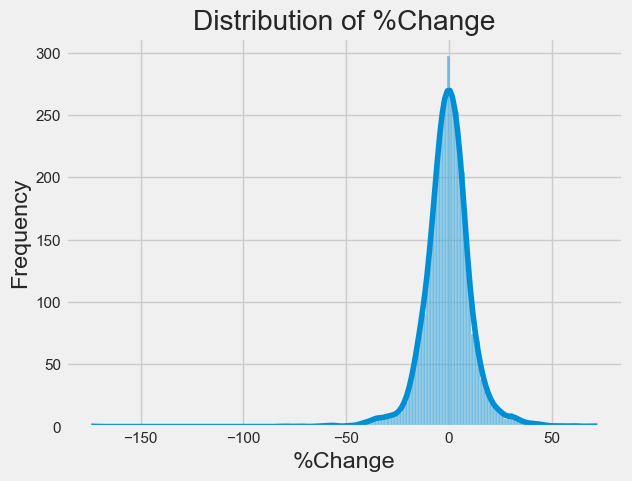

In [6]:
# Viewing the distribution of '%Change'
sns.histplot(app_cross_df['%Change'], kde=True)  # Histogram with Kernel Density Estimate
plt.title('Distribution of %Change')
plt.xlabel('%Change')
plt.ylabel('Frequency')
plt.show()

In [7]:
app_cross_df['%Change'].describe()

count    4124.000000
mean       -0.468394
std        11.729480
min      -174.065421
25%        -6.277815
50%        -0.246024
75%         5.489440
max        72.327965
Name: %Change, dtype: float64

In [8]:
app_cross_df['%Change'].mean()

-0.46839355967266355

### Preparing X and y

In [9]:
# Specifying the features to be removed for creating X
features_to_exclude = ['original index', 'Ticker', 'Date', 'Open', 'MA200', 'Days', '%Change', 'Profitable']

# Creating the X DF excluding the specified features
X = app_cross_df.drop(columns=features_to_exclude)

X.head()

,Close,Volume,quarter,Asset Turnover,Current Ratio,Days Sales In Receivables,Debt/Equity Ratio,Gross Margin,Inventory Turnover Ratio,Long-term Debt / Capital,Net Profit Margin,Operating Margin,ROE - Return On Equity,Receiveable Turnover,Return On Tangible Equity,MA50,Crossover,Ticker_encoded
0,19.60,2054200,3,0.1603,2.5128,61.9613,0.3956,55.3672,0.7844,0.2834,18.3212,14.6893,5.6962,1.4525,6.5237,21.4990,-1,0.55
1,22.19,3484900,4,0.1802,2.5735,46.8976,0.4112,54.8946,0.9553,0.2914,11.2199,11.2199,3.4539,1.9191,3.9623,21.0246,1,0.55
2,23.34,3035600,4,0.1914,2.2075,45.7469,0.6453,54.6335,1.0202,0.3922,12.4481,13.1397,5.5659,1.9673,7.2058,24.0260,-1,0.55
3,23.47,3817200,2,0.1897,1.7034,48.8942,0.7522,55.4258,0.9629,0.1646,11.8819,13.1181,5.4816,1.8407,7.5579,22.7158,1,0.55
4,17.75,6326300,4,0.2114,2.3925,46.7927,0.8304,56.0432,1.0077,0.4537,15.5976,17.0155,9.0270,1.9234,13.7092,21.9852,-1,0.55


In [10]:
X.shape

(4124, 18)

In [11]:
# Creating y
y = app_cross_df.Profitable
print(y.head())
y.info()

0    0
1    1
2    1
3    1
4    1
Name: Profitable, dtype: int64
<class 'pandas.core.series.Series'>
RangeIndex: 4124 entries, 0 to 4123
Series name: Profitable
Non-Null Count  Dtype
--------------  -----
4124 non-null   int64
dtypes: int64(1)
memory usage: 32.3 KB


#### *Train/Test Split*

In [12]:
# Taking 75% of the data for training the models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=102)

In [13]:
print(X.shape, X_train.shape, X_test.shape, y.shape, y_train.shape, y_test.shape)

(4124, 18) (3093, 18) (1031, 18) (4124,) (3093,) (1031,)


#### *We'll use the model trained on the X_train of the <span style="text-decoration: underline;">main part</span> of the project and apply it to y_test of the dataset of the <span style="text-decoration: underline;">appendix</span>*


#### *Loading the scaler and the model saved in the main part of the project*

In [14]:
# Loading the scaler from the previuosly saved file
sc1 = joblib.load('X_train-scaler.pkl')

# Loading the model from the previuosly saved file
GBM1 = joblib.load('V2GBMmodel.pkl')    

#### *Features Scaling*

In [15]:
# Applying Feature Scaling (StandardScaler)
X_test_array = sc1.transform(X_test)

# The output is a NumPy array, which is also OK for being used for the models but we prefer it as a DF
X_test1 = pd.DataFrame(X_test_array, columns=X.columns)

In [16]:
X_test1.head(1)

,Close,Volume,quarter,Asset Turnover,Current Ratio,Days Sales In Receivables,Debt/Equity Ratio,Gross Margin,Inventory Turnover Ratio,Long-term Debt / Capital,Net Profit Margin,Operating Margin,ROE - Return On Equity,Receiveable Turnover,Return On Tangible Equity,MA50,Crossover,Ticker_encoded
0,1.673577,-0.173636,-0.518579,2.525298,-0.175048,-0.536591,-0.366085,-0.396887,1.564801,13.626568,0.005639,0.086897,-0.140086,0.229735,-0.028845,1.601596,1.048043,1.442375


In [17]:
X_test1.shape

(1031, 18)

In [18]:
y_test.shape

(1031,)

In [19]:
y_test.head()

1837    0
3858    0
4022    0
1782    1
2915    0
Name: Profitable, dtype: int64

#### *Applying the selected model GBM*

In [20]:
y_pred1 = GBM1.predict(X_test1)

In [21]:
cmat1 = confusion_matrix(y_test, y_pred1)
cmat1

array([[488,  83],
       [308, 152]], dtype=int64)

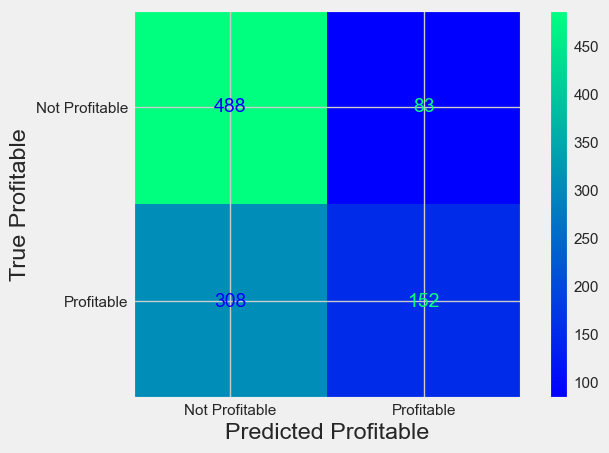

In [22]:
class_labels = ['Not Profitable', 'Profitable']
cmap = 'winter'
cm_display = ConfusionMatrixDisplay(confusion_matrix = cmat1, display_labels = class_labels)
cm_display.plot(cmap=cmap, values_format='.4g')
plt.xlabel('Predicted Profitable')
plt.ylabel('True Profitable')
plt.show()

In [23]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.61      0.85      0.71       571
           1       0.65      0.33      0.44       460

    accuracy                           0.62      1031
   macro avg       0.63      0.59      0.58      1031
weighted avg       0.63      0.62      0.59      1031



### Creating a DF which shows all the Positive (True & False) predictions with their respective '%Change' values

In [24]:
"""
Creating a DataFrame (DFB) comparing the predicted y (y_pred) to the actual y (y_test).
The 'original index' shows the location of each y selected for the test (in this case, 
when applying it to the full dataset, it is y itself and not 'y_test') for later locating 
the corresponding values of the %Change of the price in the DF from which X and y were derived (app_cross_df)
"""

# Creating a DataFrame with original index, y_test, and y_pred to compare the y test/predicted
DFB = pd.DataFrame({'original index': X_test1.index, 'y_true': y_test, 'y_pred1': y_pred1})

# Identifying True Positive and False Positive predictions (tp = True Positive, fp = False Positive) indices
tp_indices = (DFB['y_true'] == 1) & (DFB['y_pred1'] == 1)
fp_indices = (DFB['y_true'] == 0) & (DFB['y_pred1'] == 1)

# Getting the original lists of indices of X_test for True Positive and False Positive predictions
tp_indices_in_DFB = DFB.loc[tp_indices, 'original index'].tolist()
fp_indices_in_DFB = DFB.loc[fp_indices, 'original index'].tolist()

print("Number of True Positive predictions:", len(tp_indices_in_DFB))
print("Number of False Positive predictions:", len(fp_indices_in_DFB))


Number of True Positive predictions: 152
Number of False Positive predictions: 83


In [25]:
DFB.shape

(1031, 3)

In [26]:
DFB.head()

,original index,y_true,y_pred1
1837,0,0,1
3858,1,0,0
4022,2,0,0
1782,3,1,0
2915,4,0,0


In [27]:
DFB.sort_values(by='original index', inplace=True)
DFB.head()

,original index,y_true,y_pred1
1837,0,0,1
3858,1,0,0
4022,2,0,0
1782,3,1,0
2915,4,0,0


In [28]:
# Merging 'original_index' and '%Change' back to X_test to create a new DataFrame
merged_df = pd.merge(X_test1, app_cross_df[['original index', '%Change']], left_index=True, right_index=True, how='left')

# Adding a new column, 'Prediction_Type', which shows the TP and FP predictions
merged_df['Prediction_Type'] = ''

# Setting the values of 'Prediction_Type'
merged_df.loc[(DFB['y_true'].values == 1) & (DFB['y_pred1'].values == 1), 'Prediction_Type'] = 'True Positive'
merged_df.loc[(DFB['y_true'].values == 0) & (DFB['y_pred1'].values == 1), 'Prediction_Type'] = 'False Positive'

merged_df.sort_values(by='original index', inplace=True)

# Displaying the DataFrame
merged_df.head()


,Close,Volume,quarter,Asset Turnover,Current Ratio,Days Sales In Receivables,Debt/Equity Ratio,Gross Margin,Inventory Turnover Ratio,Long-term Debt / Capital,...,Operating Margin,ROE - Return On Equity,Receiveable Turnover,Return On Tangible Equity,MA50,Crossover,Ticker_encoded,original index,%Change,Prediction_Type
0,1.673577,-0.173636,-0.518579,2.525298,-0.175048,-0.536591,-0.366085,-0.396887,1.564801,13.626568,...,0.086897,-0.140086,0.229735,-0.028845,1.601596,1.048043,1.442375,318,-2.040816,False Positive
1,2.247728,-0.177010,-1.411356,-0.157782,4.105437,0.063115,-0.132433,2.093206,-0.386756,-0.910050,...,1.780253,0.010205,-0.182698,0.133880,2.339432,-0.954160,-0.576575,413,1.937810,
2,1.779803,-0.182179,0.374197,0.471024,-0.243115,0.232346,0.007290,0.304735,-0.181928,0.190843,...,0.262862,0.079362,-0.223272,3.862408,2.038995,-0.954160,-0.607635,685,2.913453,
3,-0.392799,0.721764,1.266974,-0.289260,-0.525701,0.213506,-0.087618,-1.472296,0.859740,-0.317863,...,-0.117367,-0.070833,-0.219339,0.114898,-0.372449,-0.954160,-0.086142,815,3.664252,
4,-0.059173,-0.175357,0.374197,-0.145829,0.711686,0.037859,-0.069831,-0.180474,-0.192822,-0.097641,...,0.411998,-0.035414,-0.175458,-0.296014,-0.011170,-0.954160,0.336977,885,29.183099,


In [29]:
merged_df.shape

(1031, 21)

In [30]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031 entries, 0 to 1030
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Close                      1031 non-null   float64
 1   Volume                     1031 non-null   float64
 2   quarter                    1031 non-null   float64
 3   Asset Turnover             1031 non-null   float64
 4   Current Ratio              1031 non-null   float64
 5   Days Sales In Receivables  1031 non-null   float64
 6   Debt/Equity Ratio          1031 non-null   float64
 7   Gross Margin               1031 non-null   float64
 8   Inventory Turnover Ratio   1031 non-null   float64
 9   Long-term Debt / Capital   1031 non-null   float64
 10  Net Profit Margin          1031 non-null   float64
 11  Operating Margin           1031 non-null   float64
 12  ROE - Return On Equity     1031 non-null   float64
 13  Receiveable Turnover       1031 non-null   float

In [31]:
# Counting the distinct values in'Prediction_Type' to check VS the confusion matrix values
print(merged_df['Prediction_Type'].value_counts())


Prediction_Type
                  796
True Positive     152
False Positive     83
Name: count, dtype: int64


#### Saving the DF with the positive predictions

In [32]:
merged_df.to_excel('app_new_positive_predictions_df3.xlsx', index=False)

In [33]:
# Calculating the average %Change for the True Positive predictions
avg_change_tp = merged_df.loc[merged_df['Prediction_Type'] == 'True Positive', '%Change'].mean()

# Calculating the average %Change for the False Positive predictions
avg_change_fp = merged_df.loc[merged_df['Prediction_Type'] == 'False Positive', '%Change'].mean()

print("Average %Change for True Positive:", round(avg_change_tp, 2), '%')
print("Average %Change for False Positive:", round(avg_change_fp, 2), '%')


Average %Change for True Positive: -1.08 %
Average %Change for False Positive: -1.6 %


In [34]:
# Calculating the Expected Value by the formula
tp = merged_df['Prediction_Type'].value_counts()['True Positive'] # Number of true positive predictions
fp = merged_df['Prediction_Type'].value_counts()['False Positive'] # Number of false positive predictions
PrTP = tp / (tp + fp) # Probability of true positive prediction
PrFP = fp / (tp + fp) # Probability of false positive prediction
AveragePTP = avg_change_tp # Average value of %Change of the tp cases
AveragePFP = avg_change_fp # Average value of %Change of the fp cases

Expected_Value = PrTP * AveragePTP + PrFP * AveragePFP

print('The Expected Value of the profit rate is', round(Expected_Value, 5), '%')

The Expected Value of the profit rate is -1.26429 %


In [35]:
# Calculating the average profit rate for all profitable predicted events (True or False)
# Filtering rows where Prediction Type is 'True Positive' or 'False Positive'
filtered_df = merged_df[(merged_df['Prediction_Type'] == 'True Positive') | (merged_df['Prediction_Type'] == 'False Positive')]

# Calculating the average of '%Change' for the filtered data
average_change = filtered_df['%Change'].mean()

print("Average %Change for True Positive and False Positive predictions:", round(average_change, 5), '%')

Average %Change for True Positive and False Positive predictions: -1.26429 %


As expected - in both ways we get the same result

#### Checking the significance of the Expected Value result

In [36]:
# Defining the null hypothesis (H0): 
# As can be seen in the %Change histogram, its distribution is normal with mean very close to 0
null_hypothesis = app_cross_df['%Change'].mean() # This value is used for the population mean
print('Null hypothesis = ', null_hypothesis, '%')

# Performing t-test
t_stat, p_value = stats.ttest_1samp(a = filtered_df['%Change'], popmean = null_hypothesis)

print("p-value is:", p_value)

# Comparing p-value to significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. The expected value is significant.")
else:
    print("Fail to reject the null hypothesis. The expected value is not significant.")

Null hypothesis =  -0.46839355967266355 %
p-value is: 0.3303640428819312
Fail to reject the null hypothesis. The expected value is not significant.


### The null hypothesis is NOT rejected. <font color=red>The expected value is NOT significant.

[<font color='purple'>**Go to the Main notebook**](Profitable_Trades_Predictions_by_MA50_MA200_Crossovers_V2.ipynb)